In [1]:
# import library
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

sns.set(style="darkgrid")

from pylab import rcParams

rcParams["figure.figsize"] = 15, 8

from functools import reduce
import operator

import os
import requests

import holoviews as hv
import hvplot.pandas

In [2]:
while True:
    try:
        nyse_hist = pd.read_csv("./Data/NYSE.csv")
        nyse_hist_10_years = pd.read_csv("./Data/NYSE_10years.csv")
        nyse_hist["Date"] = pd.to_datetime(nyse_hist["Date"])
        nyse_hist_10_years["Date"] = pd.to_datetime(nyse_hist_10_years["Date"])
        nyse_hist.set_index("Date", inplace=True)
        nyse_hist_10_years.set_index("Date", inplace=True)
        break
    except FileNotFoundError:
        nyse = yf.Ticker("^NYA")
        nyse.info
        nyse_hist = nyse.history(period="365d")
        nyse_hist.to_csv("./Data/NYSE.csv")
        nyse_hist_10_years = nyse.history(period="3650d")
        nyse_hist_10_years.to_csv("./Data/NYSE_10years.csv")

In [3]:
# Test
# get covid-19 info
# https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/141607
# https://towardsdatascience.com/covid-19-data-collection-a-python-api-story-347aafa95e69
def covid_19_data_collection(countries=["US", "FR"]):
    import COVID19Py as cpy

    covid = cpy.COVID19(url="https://covid-tracker-us.herokuapp.com")

    for i in range(len(countries)):
        all_location_json = covid.getLocationByCountryCode(
            countries[i], timelines=True
        )[0]

        confirmed = pd.DataFrame.from_dict(
            all_location_json["timelines"]["confirmed"]["timeline"], orient="index",
        ).rename(columns={0: "{}_confirmed".format(countries[i])})

        # deaths = pd.DataFrame.from_dict(
        #    all_location_json["timelines"]["deaths"]["timeline"], orient="index",
        # ).rename(columns={0: "{}_deaths".format(countries[i])})

        # recovered = pd.DataFrame.from_dict(
        #     all_location_json["timelines"]["recovered"]["timeline"], orient="index",
        # ).rename(columns={0: "{}_recovered".format(countries[i])})

        if i == 0:
            covid_df = confirmed
        else:
            covid_df = covid_df.join(confirmed)
        # covid_df = covid_df.join(deaths)
        # covid_df = covid_df.join(recovered)
    return covid_df

In [4]:

countries = ["US", "FR", "ES", "ZA", "BR", "RU"]
covid_df = covid_19_data_collection(countries)
covid_df.index = pd.to_datetime(covid_df.index).date

In [5]:
# get unployment rate US information
# https://www.bls.gov/developers/api_python.htm
# Unemployment Rate - LNS14000000
# Discouraged Workers - LNU05026645
# Persons At Work Part Time for Economic Reasons - LNS12032194
# Unemployment Rate - 25 Years & Over, Some College or Associate Degree - LNS14027689
def unemployment_rate(start_year=2019, end_year=2020):
    import requests
    import json

    headers = {"Content-type": "application/json"}
    data = json.dumps(
        {
            "seriesid": ["LNS14000000"],
            "startyear": "{}".format(start_year),
            "endyear": "{}".format(end_year),
        }
    )
    p = requests.post(
        "https://api.bls.gov/publicAPI/v2/timeseries/data/", data=data, headers=headers
    )
    json_data = json.loads(p.text)
    result = pd.DataFrame.from_dict(json_data["Results"]["series"][0]["data"])
    return result

In [6]:

unemployment_df = unemployment_rate(start_year=2015, end_year=2020).drop(
    columns="footnotes"
)

unemployment_df["Date"] = (
    unemployment_df["year"] + "-" + unemployment_df["periodName"] + "-" + "01"
)
unemployment_df["Date"] = pd.to_datetime(unemployment_df["Date"], format="%Y-%B-%d")
unemployment_df.set_index("Date", inplace=True)

In [7]:
# Get business cycle:
# Business cycle is the data/graph of movement in GDP around its long-term growth trend
# https://codingandfun.com/economic-indicators-with-python/
def checkindicator(url):
    import requests
    import json

    r = requests.get(url)
    r = r.json()
    periods = r["series"]["docs"][0]["period"]
    values = r["series"]["docs"][0]["value"]
    dataset = r["series"]["docs"][0]["dataset_name"]

    indicators = pd.DataFrame(values, index=periods)
    indicators.columns = [dataset]
    return indicators

In [8]:

GDPgrowth = checkindicator(
    "https://api.db.nomics.world/v22/series/WB/WDI/NY.GDP.MKTP.KD.ZG-EU?observations=1"
)

nyse_hist_10_years = nyse_hist

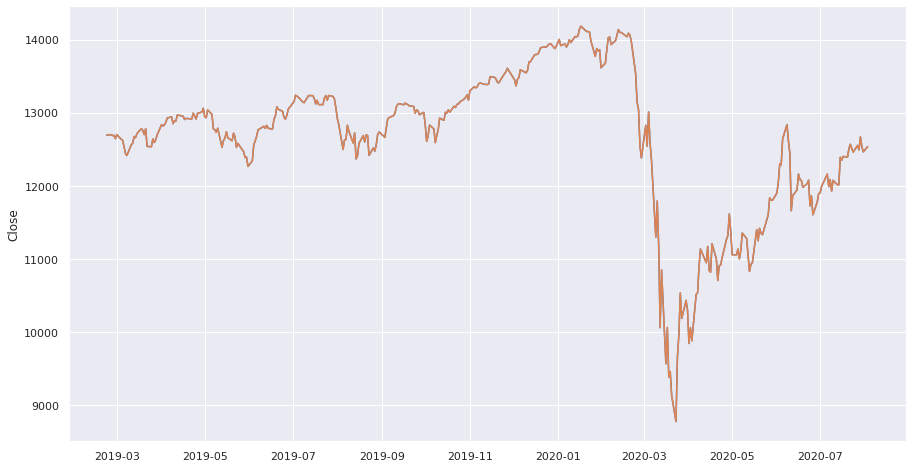

In [9]:
# # Visualize the data
# NYSE price from 2019 to 2020

from pylab import rcParams

rcParams["figure.figsize"] = 15, 8
# plt.figure(figsize=(15,8))
nyse_plot = sns.lineplot(x=nyse_hist.index.values, y="Close", data=nyse_hist)


nyse_plot_10_years = sns.lineplot(
    x=nyse_hist_10_years.index.values, y="Close", data=nyse_hist_10_years
)

No handles with labels found to put in legend.


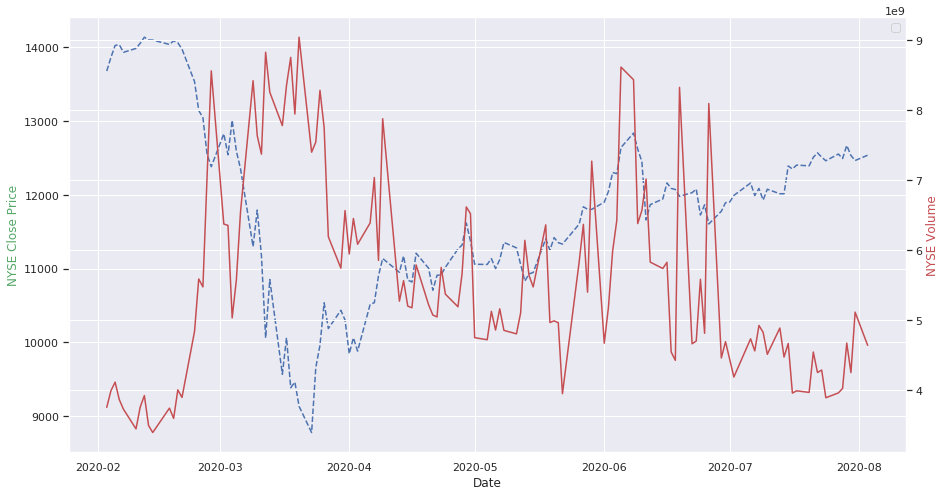

In [10]:
from pylab import rcParams

rcParams["figure.figsize"] = 15, 8

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(nyse_hist["Close"].loc["2020-02-01":], "--b", label="NYSE")
ax2.plot(nyse_hist["Volume"].loc["2020-02-01":], "-r")

ax1.set_xlabel("Date")
ax1.set_ylabel("NYSE Close Price", color="g")
ax2.set_ylabel("NYSE Volume", color="r")

plt.legend()
plt.show()

Close  US_confirmed  FR_confirmed  ES_confirmed  ZA_confirmed  \
Date                                                                           
2019-02-22  12694.52           NaN           NaN           NaN           NaN   
2019-02-25  12700.19           NaN           NaN           NaN           NaN   
2019-02-26  12686.56           NaN           NaN           NaN           NaN   
2019-02-27  12689.87           NaN           NaN           NaN           NaN   
2019-02-28  12644.81           NaN           NaN           NaN           NaN   

            BR_confirmed  RU_confirmed  
Date                                    
2019-02-22           NaN           NaN  
2019-02-25           NaN           NaN  
2019-02-26           NaN           NaN  
2019-02-27           NaN           NaN  
2019-02-28           NaN           NaN

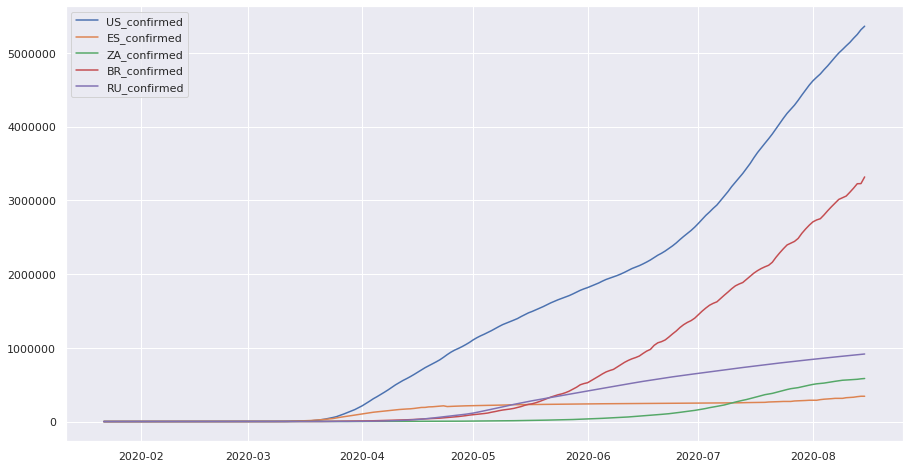

In [11]:

# COVID-19 Infection Rate

# plt.figure(figsize=(15,8))
covid_plot = sns.lineplot(data=covid_df.drop(columns="FR_confirmed"), dashes=False)

# ## Combine graph

nyse_hist_close = nyse_hist.drop(
    columns=["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"]
)
combined_df = nyse_hist_close.join(covid_df)
combined_df.head()

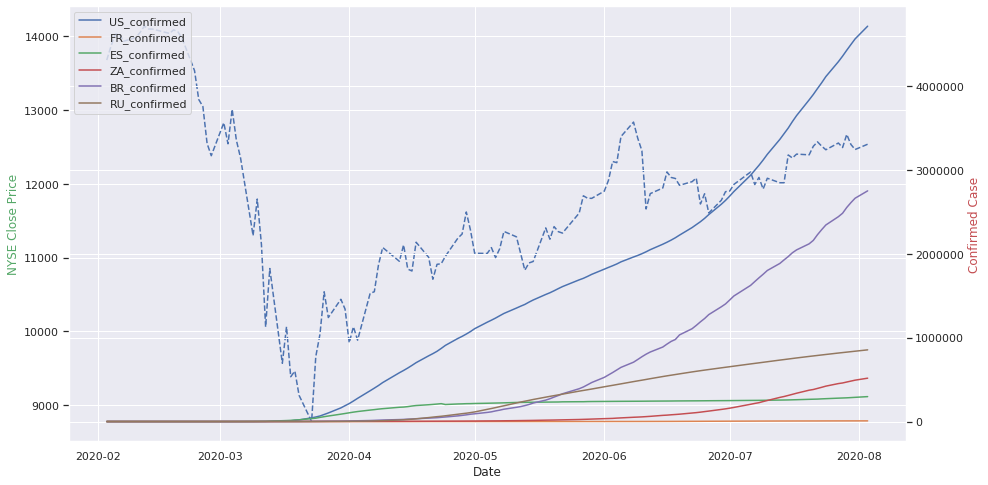

In [12]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(combined_df["Close"].loc["2020-02-01":], "--b", label="NYSE")
ax2.plot(combined_df.drop(columns="Close").loc["2020-02-01":])

ax1.set_xlabel("Date")
ax1.set_ylabel("NYSE Close Price", color="g")
ax2.set_ylabel("Confirmed Case", color="r")

plt.legend(combined_df.drop(columns="Close").columns.values)
plt.show()

In [13]:
# Create plotting object
plot_data = hv.Dataset(nyse_hist, kdims=["Date"], vdims=["Close"])

In [14]:
# Create scatter plot

black_tuesday = pd.to_datetime("2020-03-15")

vline = hv.VLine(black_tuesday).options(color="#FF7E47")

m = (
    hv.Scatter(plot_data)
    .options(width=700, height=400)
    .redim("NYSE Share Trading Close Price")
    .hist()
    * vline
    * hv.Text(
        black_tuesday + pd.DateOffset(months=10), 4e7, "Covid-19 Crash", halign="left"
    ).options(color="#FF7E47")
)
m

:AdjointLayout
   :Overlay
      .Scatter.I :Scatter   [Date]   (Close)
      .VLine.I   :VLine   [x,y]
      .Text.I    :Text   [x,y]
   :Histogram   [Close]   (Close_frequency)

In [15]:

# ## Chow Test

# +
# https://github.com/jtloong/chow_test/blob/master/tests/test_analysis.ipynb

import numpy as np
from scipy.stats import f


def f_value(y1, x1, y2, x2):
    """This is the f_value function for the Chow Break test package
    Args:
        y1: Array like y-values for data preceeding the breakpoint
        x1: Array like x-values for data preceeding the breakpoint
        y2: Array like y-values for data occuring after the breakpoint
        x2: Array like x-values for data occuring after the breakpoint

    Returns:
        F-value: Float value of chow break test
    """

    def find_rss(y, x):
        """This is the subfunction to find the residual sum of squares for a given set of data
        Args:
            y: Array like y-values for data subset
            x: Array like x-values for data subset

        Returns:
            rss: Returns residual sum of squares of the linear equation represented by that data
            length: The number of n terms that the data represents
        """
        A = np.vstack([x, np.ones(len(x))]).T
        rss = np.linalg.lstsq(A, y, rcond=None)[1]
        length = len(y)
        return (rss, length)

    rss_total, n_total = find_rss(np.append(y1, y2), np.append(x1, x2))
    rss_1, n_1 = find_rss(y1, x1)
    rss_2, n_2 = find_rss(y2, x2)

    chow_nom = (rss_total - (rss_1 + rss_2)) / 2
    chow_denom = (rss_1 + rss_2) / (n_1 + n_2 - 4)
    return chow_nom / chow_denom

In [16]:
def p_value(y1, x1, y2, x2, **kwargs):
    F = f_value(y1, x1, y2, x2, **kwargs)
    if not F:
        return 1
    df1 = 2
    df2 = len(x1) + len(x2) - 4

    # The survival function (1-cdf) is more precise than using 1-cdf,
    # this helps when p-values are very close to zero.
    # -f.logsf would be another alternative to directly get -log(pval) instead.
    p_val = f.sf(F[0], df1, df2)
    return p_val

In [17]:

y1 = nyse_hist[nyse_hist.index < pd.to_datetime("2020-01-01")]["Volume"]
x1 = nyse_hist[nyse_hist.index < pd.to_datetime("2020-01-01")]["Close"]
y2 = nyse_hist[nyse_hist.index >= pd.to_datetime("2020-01-01")]["Volume"]
x2 = nyse_hist[nyse_hist.index >= pd.to_datetime("2020-01-01")]["Close"]

f_test = f_value(y1, x1, y2, x2)
f_test

p_val = p_value(y1, x1, y2, x2)
p_val

# ## This p-value < 0.05 indicate that there is a structure break

4.9898195720854524e-30

In [18]:
# Create plotting object
plot_data = hv.Dataset(nyse_hist, kdims=["Date"], vdims=["Volume"])

# Create scatter plot

black_tuesday = pd.to_datetime("2020-03-15")

vline = hv.VLine(black_tuesday).options(color="#FF7E47")

m = (
    hv.Scatter(plot_data)
    .options(width=700, height=400)
    .redim("NYSE Share Trading Volume")
    .hist()
    * vline
    * hv.Text(
        black_tuesday + pd.DateOffset(months=10), 4e7, "Covid-19 Crash", halign="left"
    ).options(color="#FF7E47")
)
m

:AdjointLayout
   :Overlay
      .Scatter.I :Scatter   [Date]   (Volume)
      .VLine.I   :VLine   [x,y]
      .Text.I    :Text   [x,y]
   :Histogram   [Volume]   (Volume_frequency)

In [19]:
%%opts Scatter [width=400 height=200]

nyse_hist["Date_"] = nyse_hist.index.values
nyse_hist["Quarter"] = nyse_hist.Date_.dt.quarter

In [20]:


def second_order(days_window):
    data_imputed = nyse_hist
    data_imputed.Volume = data_imputed.Volume.interpolate()

    return hv.Scatter(
        pd.concat(
            [data_imputed.Date_, data_imputed.Volume.rolling(days_window).mean()],
            names=["Date", "Volumne Trend"],
            axis=1,
        ).dropna()
    ).redim(Volume="Mean Trend") + hv.Scatter(
        pd.concat(
            [data_imputed.Date_, data_imputed.Volume.rolling(days_window).cov()],
            names=["Date", "Volumne Variance"],
            axis=1,
        ).dropna()
    ).redim(
        Volume="Volume Variance"
    ).options(
        color="#FF7E47"
    )


hv.DynamicMap(second_order, kdims=["days_window"]).redim.range(days_window=(7, 1000))

:DynamicMap   [days_window]
   :Layout
      .Scatter.I  :Scatter   [Date_]   (Mean Trend)
      .Scatter.II :Scatter   [Date_]   (Volume Variance)

In [21]:
# ## ACF and PACF Volume

In [22]:
# %%opts Bars [width=400 height=300]
from statsmodels.tsa.stattools import acf, pacf


def auto_correlations(start_year, window_years):
    start_year = pd.to_datetime(f"{start_year}-01-01")
    window_years = pd.DateOffset(years=window_years)

    data_window = nyse_hist
    data_window = data_window.loc[
        (
            (data_window.Date_ >= start_year)
            & (data_window.Date_ <= (start_year + window_years))
        ),
        :,
    ]

    return hv.Bars(acf(data_window.Volume.interpolate().dropna())).redim(
        y="Autocorrelation", x="Lags"
    ) + hv.Bars(pacf(data_window.Volume.interpolate().dropna())).redim(
        y="Patial Autocorrelation", x="Lags"
    ).options(
        color="#FF7E47"
    )


hv.DynamicMap(auto_correlations, kdims=["start_year", "window_years"]).redim.range(
    start_year=(nyse_hist.Date_.min().year, nyse_hist.Date_.max().year),
    window_years=(1, 25),
)

/home/haininhhoang94/anaconda3/envs/pyds/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


:DynamicMap   [start_year,window_years]
   :Layout
      .Bars.I  :Bars   [Lags]   (Autocorrelation)
      .Bars.II :Bars   [Lags]   (Patial Autocorrelation)

In [23]:
# Clearly see a prediction/panic mode in NYSE before the first case in Covid-19 happened

In [24]:
unemployment_df.head()
combined_df_2 = combined_df.join(unemployment_df).drop(
    columns=["year", "period", "periodName", "latest"]
)

combined_df_2 = combined_df_2.dropna().rename(columns={"value": "Unployment Rate"})
combined_df_2

# Graph a chart plot to analyze the unemployment rate

Close  US_confirmed  FR_confirmed  ES_confirmed  ZA_confirmed  \
Date                                                                           
2020-04-01   9844.85      214205.0          51.0      104118.0        1380.0   
2020-05-01  11058.57     1106829.0         128.0      215216.0        5951.0   
2020-06-01  11900.24     1816479.0         499.0      239638.0       34357.0   
2020-07-01  11901.55     2687588.0        4268.0      249659.0      159333.0   

            BR_confirmed  RU_confirmed Unployment Rate  
Date                                                    
2020-04-01        6836.0        2777.0            14.7  
2020-05-01       92202.0      114431.0            13.3  
2020-06-01      526447.0      414328.0            11.1  
2020-07-01     1448753.0      653479.0            10.2

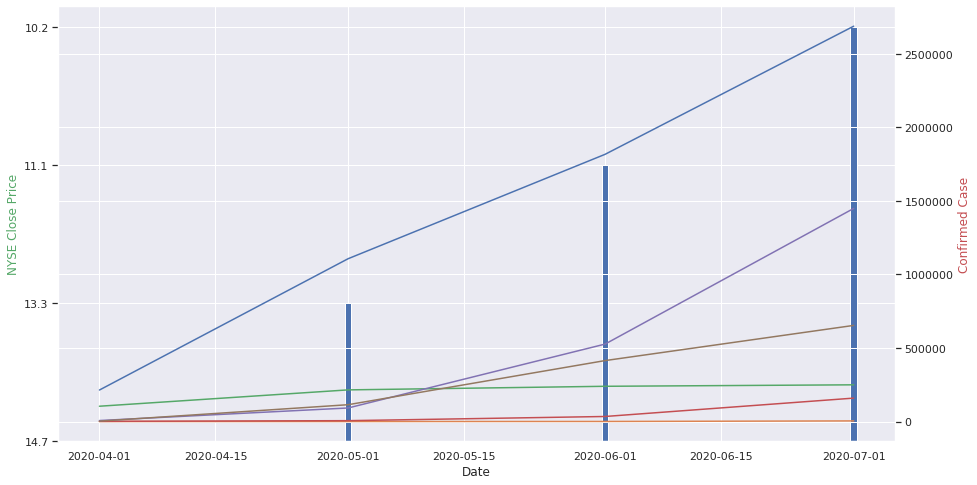

In [25]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(combined_df_2.index.values, combined_df_2["Unployment Rate"])
ax2.plot(
    combined_df_2.index.values, combined_df_2.drop(columns=["Close", "Unployment Rate"])
)

ax1.set_xlabel("Date")
ax1.set_ylabel("NYSE Close Price", color="g")
ax2.set_ylabel("Confirmed Case", color="r")

# plt.legend(combined_df.drop(columns='Close').columns.values)
plt.show()

In [26]:

# NYSE predict the unemployment and GDP

# ## ACF and PACF for Price
# Inspect to see pattern in NYSE. Since ACF and PACF is to analyze seasonal/pattern, we will apply the technique to NYSE 10 years

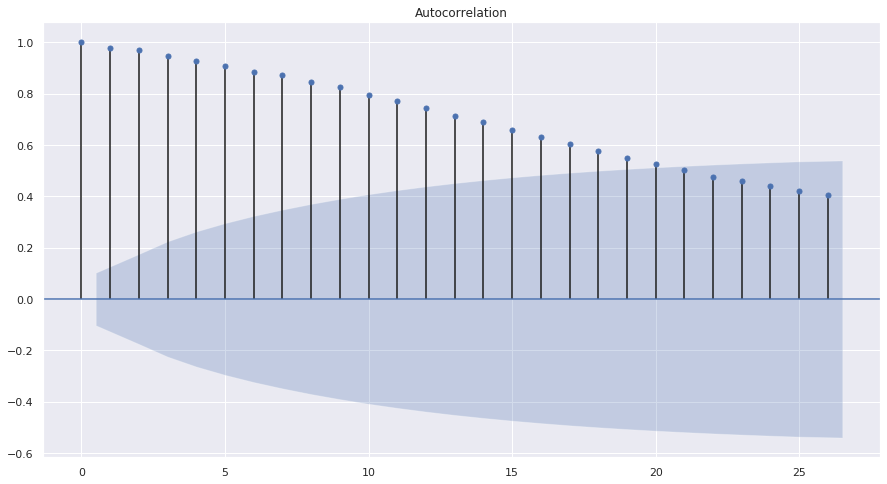

In [27]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(nyse_hist_10_years["Close"])
plt.show()

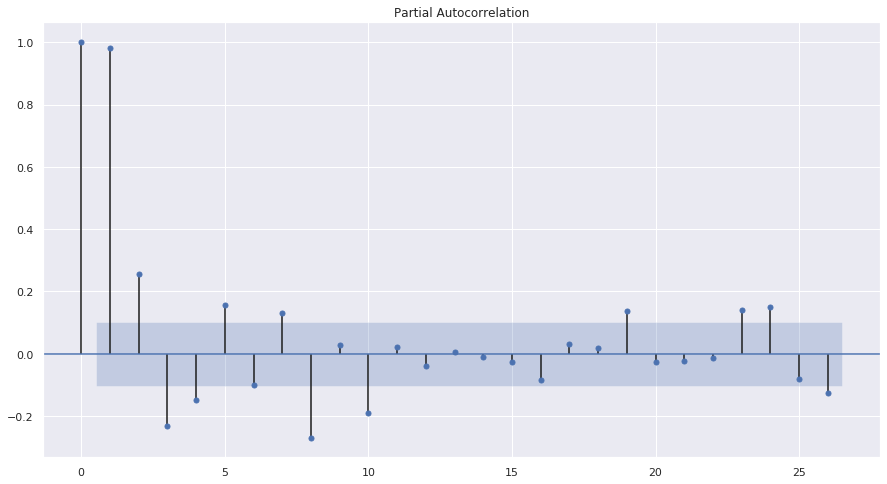

In [28]:
sm.graphics.tsa.plot_pacf(nyse_hist_10_years["Close"])
plt.show()

In [29]:

# With log return

In [30]:
def nans(shape, dtype=float):
    # To generate nans array
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a


def shift(price_array, n):
    # n is the number shift to the right
    result = nans(len(price_array))
    for i in range(n, len(price_array)):
        result[i] = price_array[i - n]
    return result


def Normal_Return(P_f, P_i):
    result = (P_f - P_i) / P_i
    return result


def Log_Return(P_f, P_i):
    result = np.log(P_f / P_i)
    return result

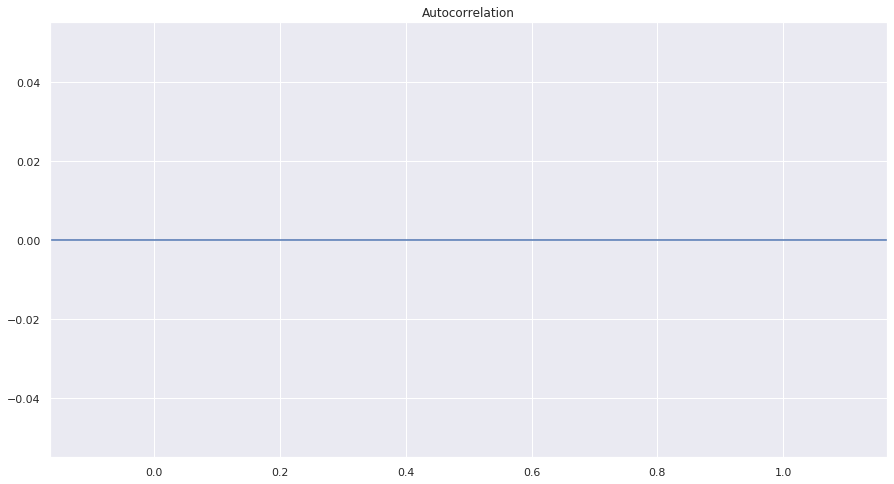

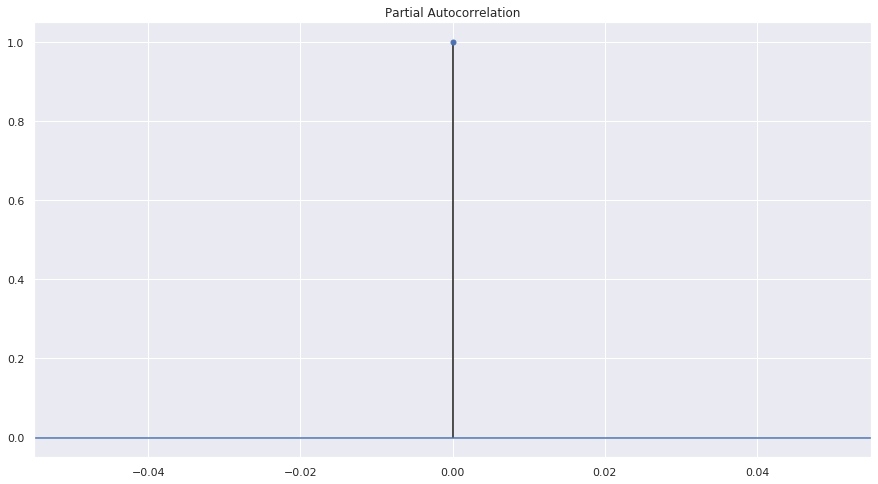

In [31]:

nyse_hist_10_years["Log Return"] = Log_Return(
    nyse_hist_10_years["Close"], shift(nyse_hist_10_years["Close"], 1)
)

nyse_hist_10_years.head()

sm.graphics.tsa.plot_acf(nyse_hist_10_years["Log Return"])
plt.show()

sm.graphics.tsa.plot_pacf(nyse_hist_10_years["Log Return"])
plt.show()

# Cannot use ACF and PACF with log return

# ## Random Walk

In [32]:
from functools import reduce
import operator

import os
import requests

import pandas as pd
import numpy as np

import holoviews as hv
import hvplot.pandas

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
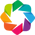

In [33]:

np.random.seed(42)
hv.extension("bokeh")
# --

In [34]:
def plot(mu, sigma, samples):
    return (
        pd.Series(np.random.normal(mu, sigma, 1000))
        .cumsum()
        .hvplot(title="Random Walks", label=f"{samples}")
    )


def prod(mu, sigma, samples):
    return reduce(
        operator.mul, list(map(lambda x: plot(mu, sigma, x), range(1, samples + 1)))
    )

In [35]:
hv.DynamicMap(prod, kdims=["mu", "sigma", "samples"]).redim.range(
    mu=(14000, 14001), sigma=(100000, 100001), samples=(30, 50)
).options(width=900, height=400)

# Random Walk for NYSE from today

# ## AS-AD Model

# Using economic growth

:DynamicMap   [mu,sigma,samples]
   :Overlay
      .Curve.A_1  :Curve   [index]   (0)
      .Curve.A_2  :Curve   [index]   (0)
      .Curve.A_3  :Curve   [index]   (0)
      .Curve.A_4  :Curve   [index]   (0)
      .Curve.A_5  :Curve   [index]   (0)
      .Curve.A_6  :Curve   [index]   (0)
      .Curve.A_7  :Curve   [index]   (0)
      .Curve.A_8  :Curve   [index]   (0)
      .Curve.A_9  :Curve   [index]   (0)
      .Curve.A_10 :Curve   [index]   (0)
      .Curve.A_11 :Curve   [index]   (0)
      .Curve.A_12 :Curve   [index]   (0)
      .Curve.A_13 :Curve   [index]   (0)
      .Curve.A_14 :Curve   [index]   (0)
      .Curve.A_15 :Curve   [index]   (0)
      .Curve.A_16 :Curve   [index]   (0)
      .Curve.A_17 :Curve   [index]   (0)
      .Curve.A_18 :Curve   [index]   (0)
      .Curve.A_19 :Curve   [index]   (0)
      .Curve.A_20 :Curve   [index]   (0)
      .Curve.A_21 :Curve   [index]   (0)
      .Curve.A_22 :Curve   [index]   (0)
      .Curve.A_23 :Curve   [index]   (0)
      .Curve.A_24 :Curve   [index]   (0)
      .Curve.A_25 :Curve   [index]   (0)
      .Curve.A_26 :Curve   [index]   (0)
      .Curve.A_27 :Curve   [index]   (0)
      .Curve.A_28 :Curve   [index]   (0)
      .Curve.A_29 :Curve   [index]   (0)
      .Curve.A_30 :Curve   [index]   (0)

In [36]:
from scipy.optimize import fsolve
from scipy.stats import iqr

pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.wb as wb

/home/haininhhoang94/anaconda3/envs/pyds/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [37]:
def P(*args, **kwargs):
    P = np.linspace(-10, 10, 100).reshape(-1, 1)
    P = P[P != 0]
    return P


def AS(P=P(), W=0, P_e=1, Z_2=0):
    return P - Z_2


def AD(P=P(), M=0, G=0, T=0, Z_1=0):
    return -P + Z_1

In [38]:


def findIntersection(fun1, fun2, x0):
    return fsolve(lambda x: fun1(x) - fun2(x), x0)


indicators = wb.get_indicators()
indicators

id  \
0        1.0.HCount.1.90usd   
1         1.0.HCount.2.5usd   
2      1.0.HCount.Mid10to50   
3           1.0.HCount.Ofcl   
4       1.0.HCount.Poor4uds   
...                     ...   
17489               w_F_skl   
17490               w_M_nsk   
17491               w_M_skl   
17492             wpremia_F   
17493             wpremia_M   

                                                    name unit  \
0                        Poverty Headcount ($1.90 a day)        
1                        Poverty Headcount ($2.50 a day)        
2                  Middle Class ($10-50 a day) Headcount        
3                Official Moderate Poverty Rate-National        
4                           Poverty Headcount ($4 a day)        
...                                                  ...  ...   
17489     Annual wage for skilled female workers  in US$        
17490     Annual wage for unskilled male workers  in US$        
17491       Annual wage for skilled male workers  in US$        
17492  Wage Premia for Females (the ratio of skilled ...        
17493  Wage Premia for Males  (the ratio of skilled m...        

                                           source  \
0                                  LAC Equity Lab   
1                                  LAC Equity Lab   
2                                  LAC Equity Lab   
3                                  LAC Equity Lab   
4                                  LAC Equity Lab   
...                                           ...   
17489  Gender Disaggregated Labor Database (GDLD)   
17490  Gender Disaggregated Labor Database (GDLD)   
17491  Gender Disaggregated Labor Database (GDLD)   
17492  Gender Disaggregated Labor Database (GDLD)   
17493  Gender Disaggregated Labor Database (GDLD)   

                                              sourceNote  \
0      The poverty headcount index measures the propo...   
1      The poverty headcount index measures the propo...   
2      The poverty headcount index measures the propo...   
3      The poverty headcount index measures the propo...   
4      The poverty headcount index measures the propo...   
...                                                  ...   
17489                                                      
17490                                                      
17491                                                      
17492                                                      
17493                                                      

                                      sourceOrganization    topics  
0      b'LAC Equity Lab tabulations of SEDLAC (CEDLAS...  Poverty   
1      b'LAC Equity Lab tabulations of SEDLAC (CEDLAS...  Poverty   
2      b'LAC Equity Lab tabulations of SEDLAC (CEDLAS...  Poverty   
3      b'LAC Equity Lab tabulations of data from Nati...  Poverty   
4      b'LAC Equity Lab tabulations of SEDLAC (CEDLAS...  Poverty   
...                                                  ...       ...  
17489                                                b''            
17490                                                b''            
17491                                                b''            
17492                                                b''            
17493                                                b''            

[17494 rows x 7 columns]

In [39]:

# ### Get GDP Growth

indicators.loc[indicators.name == "GDP growth (annual %)", :]

countries = wb.get_countries()
countries.head()

iso3c iso2c         name                      region  \
0   ABW    AW        Aruba  Latin America & Caribbean    
1   AFG    AF  Afghanistan                  South Asia   
2   AFR    A9       Africa                  Aggregates   
3   AGO    AO       Angola         Sub-Saharan Africa    
4   ALB    AL      Albania       Europe & Central Asia   

                                     adminregion          incomeLevel  \
0                                                         High income   
1                                     South Asia           Low income   
2                                                          Aggregates   
3     Sub-Saharan Africa (excluding high income)  Lower middle income   
4  Europe & Central Asia (excluding high income)  Upper middle income   

      lendingType capitalCity  longitude  latitude  
0  Not classified  Oranjestad   -70.0167  12.51670  
1             IDA       Kabul    69.1761  34.52280  
2      Aggregates                    NaN       NaN  
3            IBRD      Luanda    13.2420  -8.81155  
4            IBRD      Tirane    19.8172  41.33170

In [40]:
%%opts Curve [width=800, height=450]
gdp = wb.download(
    indicator="NY.GDP.MKTP.KD.ZG",
    country=["USA"],
    start=pd.to_datetime("1970", yearfirst=True),
    end=pd.to_datetime("2017", yearfirst=True),
)
gdp = gdp.reset_index().dropna()

gdp_unscaled = gdp

gdp.loc[gdp.country == "United States", "NY.GDP.MKTP.KD.ZG"] = (
    gdp.loc[gdp.country == "United States", "NY.GDP.MKTP.KD.ZG"]
    - gdp.loc[gdp.country == "United States", "NY.GDP.MKTP.KD.ZG"].mean()
) / iqr(gdp.loc[gdp.country == "United States", "NY.GDP.MKTP.KD.ZG"])

gdp_plot = gdp.iloc[::-1, :].hvplot.line(
    x="year", y="NY.GDP.MKTP.KD.ZG", by="country", title="GDP growth (annual %)"
)

gdp_plot

:NdOverlay   [country]
   :Curve   [year]   (NY.GDP.MKTP.KD.ZG)

In [41]:

# ## OLS Model

from statsmodels.regression.linear_model import OLS
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import linear_model
from sklearn.decomposition import PCA

import hvplot.pandas

dw = durbin_watson(pd.to_numeric(nyse_hist_10_years.Close).pct_change().dropna().values)
print(f"DW-statistic of {dw}")

# This strongly exceeds the upper-bound of the DW-statistic at the 5% level, indicating the presence of first order correlation.
# => Market is inefficient

DW-statistic of 2.539825436942308


In [42]:
# Public and monetary policies
# Students are required to investigate monetary, fiscal, and regulatory
# policies in the appropriate country and the institutional responses to
# changes brought about by the crisis. Students are
# required to discuss the challenges to traditional risk management
# strategies and financial models, given the concentration, liquidity and
# systematic risk factors and their impact on investor decisions.

In [43]:
# First, let's explore Liquidity Preference Curve before the COVID-19
# crisis from the following countries :
# - United States
# - France
# - Spain
# - Brazil
# - Russia

In [44]:
# c = countries.iso3c.sample(frac=0.1).tolist()
c = ["USA", "FRA", "RUS"]
# "ESP", "BRA", "RUS"]

money_lt = wb.download(
    indicator="FM.LBL.BMNY.GD.ZS",
    country=c,
    start=pd.to_datetime("1950", yearfirst=True),
    end=pd.to_datetime("2019", yearfirst=True),
).reset_index()

lending_rate_lt = wb.download(
    indicator="FR.INR.LEND",
    country=c,
    start=pd.to_datetime("1950", yearfirst=True),
    end=pd.to_datetime("2019", yearfirst=True),
).reset_index()

liquidity_trap_lt = money_lt.merge(lending_rate_lt, on=["year", "country"])
liquidity_trap_plot = liquidity_trap_lt.hvplot.scatter(
    x="FM.LBL.BMNY.GD.ZS", y="FR.INR.LEND", title="Liquidity Preference Data"
)
liquidity_trap_plot

:Scatter   [FM.LBL.BMNY.GD.ZS]   (FR.INR.LEND)

In [45]:
# As we see from the graph above of United States, France, and Russia
# it's appear that a downward-sloping
# relationship
# do exists. We learnt from Module 5, that "a flattening of the Liquidity Preference Curve
# which renders Monetary Policy impotent, as change in Money Supply has limited effect
# on interest rates"

# In order to be certain, we will explore by modeling the data

liquidity_trap_lt.loc[:, "FM.LBL.BMNY.GD.ZS"] = np.log(
    liquidity_trap_lt.loc[:, "FM.LBL.BMNY.GD.ZS"]
)
liquidity_trap_lt.loc[:, "FR.INR.LEND"] = np.log(
    liquidity_trap_lt.loc[:, "FR.INR.LEND"]
)

import statsmodels.api as sm

liquidity_trap_lt.loc[:, "FM.LBL.BMNY.GD.ZS**0.5"] = liquidity_trap_lt.loc[
    :, "FM.LBL.BMNY.GD.ZS"
] ** (0.5)
liquidity_trap_lt.loc[:, "FM.LBL.BMNY.GD.ZS**2"] = liquidity_trap_lt.loc[
    :, "FM.LBL.BMNY.GD.ZS"
] ** (2)


# Compare the models with the inclusion of polynomial terms
#  and control for year
lt = pd.concat(
    [
        pd.get_dummies(liquidity_trap_lt.country),
        # pd.get_dummies(liquidity_trap_lt.year),
        liquidity_trap_lt.loc[:, "FM.LBL.BMNY.GD.ZS"],
        # liquidity_trap_lt.loc[:,'FM.LBL.BMNY.GD.ZS**0.5'],
        # liquidity_trap_lt.loc[:,'FM.LBL.BMNY.GD.ZS**2'],
        liquidity_trap_lt.loc[:, "FR.INR.LEND"],
    ],
    axis=1,
).dropna(0)

exo = sm.add_constant(lt.drop(columns=["FR.INR.LEND"]), prepend=False)

# # Fit and summarize OLS model
mod = sm.OLS(lt.loc[:, "FR.INR.LEND"], exo)
res = mod.fit()

res.summary()

/home/haininhhoang94/anaconda3/envs/pyds/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/haininhhoang94/anaconda3/envs/pyds/lib/python3.6/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/haininhhoang94/anaconda3/envs/pyds/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/haininhhoang94/anaconda3/envs/pyds/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/haininhhoang94/anaconda3/envs/pyds/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            FR.INR.LEND   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sun, 16 Aug 2020   Prob (F-statistic):           3.34e-08
Time:                        14:03:46   Log-Likelihood:                -32.490
No. Observations:                  79   AIC:                             70.98
Df Residuals:                      76   BIC:                             78.09
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
France                      0          0        nan        nan           0           0
Russian Federation     1.8496      0.266      6.949      0.000       1.319       2.380
United States          1.6806      0.382      4.405      0.000       0.921       2.441
FM.LBL.BMNY.GD.ZS     -0.7794      0.238     -3.278      0.002      -1.253      -0.306
const                  3.5302      0.639      5.520      0.000       2.257       4.804
==============================================================================
Omnibus:                        2.911   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                2.852
Skew:                           0.449   Prob(JB):                        0.240
Kurtosis:                       2.755   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [46]:
# We can easily see that, the P value of the T test for Liquidity Trap is smaller
# than 0.005, which indicate a Liquidity Trap EXIST!
# Also, the Interest Rate coef is -1.5681, thus it support even more that
# before the crisis begin, Russia, United States, and France suffered from
# Liquidity Trap

In [47]:
# GDP Plot
gdp = wb.download(
    indicator="NY.GDP.PCAP.KD",
    country=c,
    start=pd.to_datetime("2010", yearfirst=True),
    end=pd.to_datetime("2020", yearfirst=True),
)
gdp = gdp.reset_index()

gdp_plot = gdp.iloc[::-1, :].hvplot.line(
    x="year",
    y="NY.GDP.PCAP.KD",
    by="country",
    title="GDP per capita (constant 2010 US$)",
)
gdp_plot

:NdOverlay   [country]
   :Curve   [year]   (NY.GDP.PCAP.KD)